## LLM Evaluation on Math problems

### 🤖 Models Considered

The following language models were considered:

---

#### 1. **GPT-4 Turbo**
- Developed by OpenAI
- One of the most capable general-purpose LLMs as of 2024
- Optimized for cost-efficiency and latency over GPT-4
- Expected to handle complex reasoning tasks with high accuracy

---

#### 2. **GPT-3.5 Turbo**
- Also developed by OpenAI
- A lightweight version of GPT-4, offering faster and cheaper inference
- Performs well on simpler arithmetic but struggles with multi-step reasoning
- Useful as a baseline for evaluating performance gains in GPT-4 Turbo

---

#### 3. **DeepSeek R1**
- Developed by DeepSeek
- Focused on mathematical and logical reasoning
- Fine-tuned specifically for structured problem solving
- Promising performance on tasks requiring step-by-step arithmetic computation

---

### 📏 Accuracy Measurement Approaches

Evaluating the correctness of LLM outputs on various math datasets presents unique challenges, especially due to the free-form nature of responses. We experimented with three complementary approaches to measure accuracy:

---

#### 1. ✅ **Explicit Human Verification**
- Involves manually inspecting each LLM response against the expected answer
- Most accurate and interpretable method
- Time-consuming and not scalable for large datasets

---

#### 2. 🔍 **Regex-Based Answer Extraction**
- A rule-based algorithm attempts to extract the final answer from the model’s response using regular expressions
- The extracted answer is then compared to the labeled correct choice
- Faster and automatable, but:
  - Fails when answers are embedded in long explanations
  - Cannot capture equivalence in phrasing or alternate formats

---

#### 3. 🤖 **Self-Validation via LLM**
- The LLM is prompted with its own response and the ground-truth answer, and asked whether they convey the same underlying answer
- Useful for capturing paraphrased answers or implicit reasoning
- Noisy and not always reliable
- Still, it offers an **interesting direction** for scalable evaluation and aligns surprisingly well with human judgments in many cases

---

**Note:** While these approaches may differ in absolute accuracy, our **relative conclusions across models remain consistent**, making them suitable for comparative analysis.



### Datasets considered

## AQUARAT Dataset Overview

The **AQUARAT (Arithmetic Questions About RATios)** dataset is a benchmark designed to test the arithmetic reasoning capabilities of language models. It consists of **multiple-choice questions** focused on **ratios, proportions, and comparative reasoning** in natural language.

### Key Features:
- 🔢 **Questions:** Text-based arithmetic questions about ratios (e.g., "The ratio of cats to dogs is 3:2...")
- 📊 **Choices:** Multiple options, only one correct
- 🧠 **Reasoning Type:** Requires multi-step arithmetic logic (not just keyword matching)

### Source:
> https://huggingface.co/datasets/deepmind/aqua_rat

### Use Cases:
- Evaluating math reasoning in LLMs
- Fine-tuning models for quantitative question answering
- Understanding generalization in arithmetic logic tasks

### Sample Question:
> *If the ratio of red marbles to blue marbles is 3:5 and there are 15 red marbles, how many blue marbles are there?*  
> **A. 10**  
> **B. 20**  
> **C. 25** ✅  
> **D. 30**

### ⚠️ Special Considerations

One unique challenge of the **AQUARAT** dataset is that it doesn't always contain questions with clearly verifiable answers. This ambiguity can make it difficult to accurately assess the reasoning capabilities of language models.

Consider the following example:

> **Question:**  
> Three birds are flying at a fast rate of **900 kilometers per hour**.  
> What is their speed in **miles per minute**?  
> *(Use conversion: 1 km = 0.6 miles)*  
>
> **Options:**  
> A) 32400  
> B) 6000  
> C) 600  
> D) 60000  
> E) 10  
>
> **Model Rationale:**  
> - Convert kilometers to miles:  
>   900 km × 0.6 = 540 miles  
> - Convert hours to minutes:  
>   1 hour = 60 minutes  
> - Speed in miles per minute:  
>   540 × 60 = **32400**  
>
> ✅ **Correct Answer:** A

This kind of problem highlights how even simple unit conversion tasks can become reasoning traps — either for the model or the human evaluating it — when the phrasing, math, or ground truth is ambiguous or misleading.


### 🔁 Reproducibility & Running the Evaluation

To reproduce the results or run your own experiments on the AQUARAT dataset using the configured LLMs, follow the steps below:

---

#### 🔑 1. API Key Setup
Before executing the script, make sure that all necessary **API keys** (e.g., OpenAI, DeepSeek) are correctly set as environment variables.  
This ensures the script can successfully query the corresponding models.

```bash
export OPENAI_API_KEY=your_key_here
export DEEPSEEK_API_KEY=your_key_here
# Add other keys as needed

python run_prompt.py --help

usage: run_prompt.py [-h] --dataset DATASET [--num_prompts NUM_PROMPTS]

Run math dataset evaluation

optional arguments:
  -h, --help            show this help message and exit
  --dataset DATASET     Name of the dataset to use (e.g., gsm8k, math_qa)
  --num_prompts NUM_PROMPTS
                        Number of prompts to evaluate from the dataset
                        
python run_prompt.py --dataset aqua_rat --num_prompts 0



In [1]:
from evaluators import summary

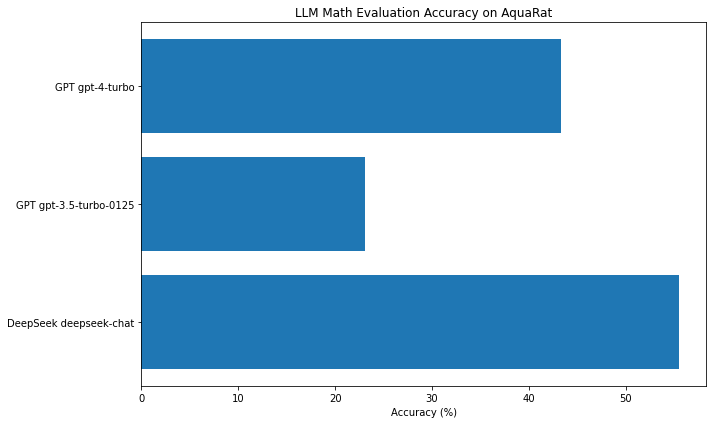

In [4]:
summary.plot_accuracy_summary('results_math_eval_aqua_rat_20250523_0403.csv', 'AquaRat')

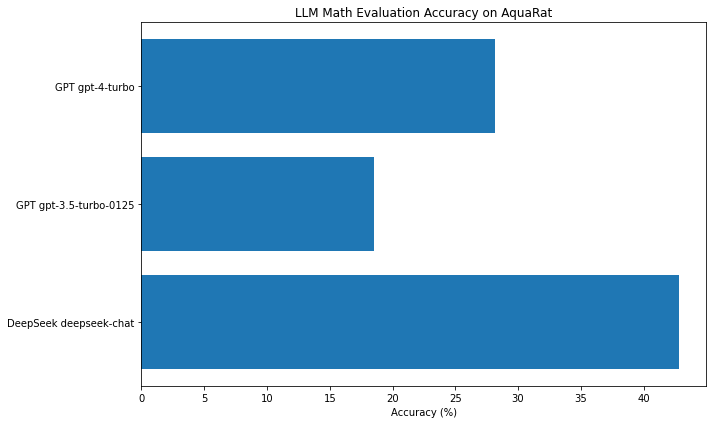

In [6]:
summary.plot_accuracy_summary_llm('evaluators/results_math_eval_aqua_rat_with_llm.csv', 'AquaRat')

In [7]:
import pandas as pd
import re
from collections import Counter
from itertools import combinations

def extract_numeric_answer(text: str) -> float:
    """
    Extracts first numeric value (int or float) after 'The answer is ...'.
    """
    match = re.search(r"The answer is.*?([-+]?\d*\.?\d+)", text, re.IGNORECASE)
    if match:
        return float(match.group(1))
    fallback = re.search(r"[-+]?\d*\.?\d+", text)
    if fallback:
        return float(fallback.group(0))
    return None

# === CONFIG ===
csv_path = "results_math_eval_aqua_rat_20250523_0403.csv"
num_models = 3
float_tolerance = 1e-2

# === Load and preprocess ===
df = pd.read_csv(csv_path)
df["prompt_id"] = [(i % (len(df) / num_models)) + 1 for i in range(len(df))]
df["predicted"] = df["response"].apply(extract_numeric_answer)

# === Analysis containers ===
same_answer_count = 0
same_and_correct = 0
same_and_wrong = 0
majority_match_count = 0

# === Main analysis ===
for _, group in df.groupby("prompt_id"):
    preds = group["predicted"].dropna().tolist()
    corrects = group["is_correct"].tolist()

    # Round predictions for equality check (or use tolerance)
    rounded_preds = [round(p, 5) for p in preds]

    # Count frequencies
    freq = Counter(rounded_preds)

    # Most common answer
    most_common, count = freq.most_common(1)[0] if freq else (None, 0)

    if count == len(group):  # all models gave the same
        same_answer_count += 1
        if all(corrects):
            same_and_correct += 1
        elif not any(corrects):
            same_and_wrong += 1
    elif count >= 2:  # majority match
        majority_match_count += 1

# === Print results ===
print("Total prompts:", df["prompt_id"].nunique())
print("Same answer across all models:", same_answer_count)
print("Same + correct:", same_and_correct)
print("Same + incorrect:", same_and_wrong)
print("Majority agreement (≥2 models match):", majority_match_count)

Total prompts: 247
Same answer across all models: 51
Same + correct: 34
Same + incorrect: 17
Majority agreement (≥2 models match): 92


In [8]:
# === Get model list ===
model_names = df["version"].unique()
matrix = pd.DataFrame(0, index=model_names, columns=model_names, dtype=int)
counts = pd.DataFrame(0, index=model_names, columns=model_names, dtype=int)

# === Compute agreement ===
for _, group in df.groupby("prompt_id"):
    preds = {
        row["version"]: row["predicted"]
        for _, row in group.iterrows()
        if pd.notnull(row["predicted"])
    }

    for model_a, model_b in combinations(model_names, 2):
        if model_a in preds and model_b in preds:
            counts.loc[model_a, model_b] += 1
            counts.loc[model_b, model_a] += 1
            if abs(preds[model_a] - preds[model_b]) < float_tolerance:
                matrix.loc[model_a, model_b] += 1
                matrix.loc[model_b, model_a] += 1

# Self-agreement = total comparisons
for model in model_names:
    total = df[df["version"] == model]["prompt_id"].nunique()
    matrix.loc[model, model] = total
    counts.loc[model, model] = total

# === Normalize (optional) ===
agreement_rate = matrix / counts

# === Output ===
print("🟦 Raw agreement counts:")
print(matrix)

print("\n📊 Agreement rate (fraction of overlap):")
print(agreement_rate.round(2))

🟦 Raw agreement counts:
                    gpt-4-turbo  gpt-3.5-turbo-0125  deepseek-chat
gpt-4-turbo                 247                  60            121
gpt-3.5-turbo-0125           60                 247             64
deepseek-chat               121                  64            247

📊 Agreement rate (fraction of overlap):
                    gpt-4-turbo  gpt-3.5-turbo-0125  deepseek-chat
gpt-4-turbo                1.00                0.24           0.49
gpt-3.5-turbo-0125         0.24                1.00           0.26
deepseek-chat              0.49                0.26           1.00


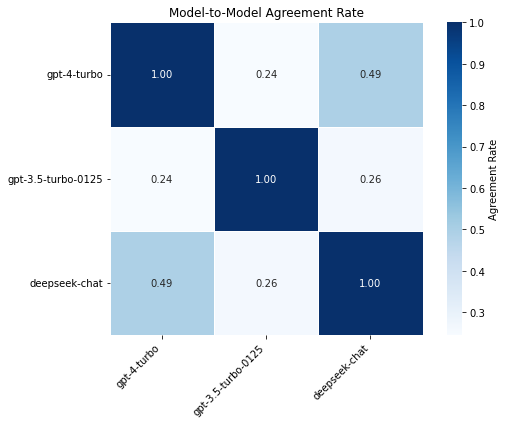

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_agreement_heatmap(agreement_df, title="Model-to-Model Agreement Rate"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        agreement_df,
        annot=True,
        cmap="Blues",
        fmt=".2f",
        linewidths=0.5,
        square=True,
        cbar_kws={"label": "Agreement Rate"}
    )
    plt.title(title)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plot_agreement_heatmap(agreement_rate)

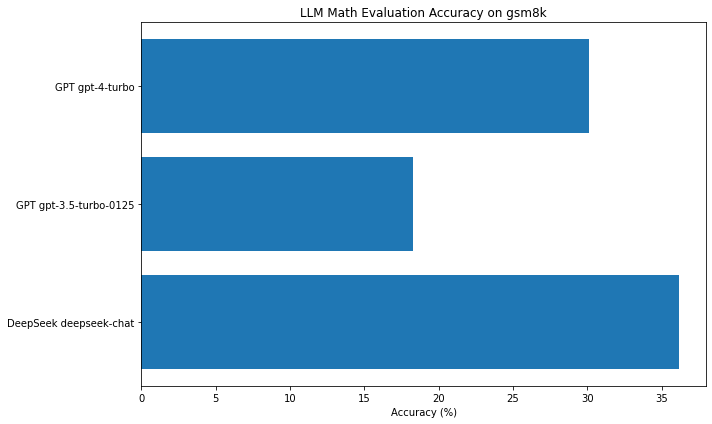

In [10]:
summary.plot_accuracy_summary_llm('evaluators/results_math_eval_gsm8k_with_llm.csv', 'gsm8k')